# Evaluation

## Environment Setup and Module Imports

This section configures the Python environment by dynamically adding the project's source directory (../src) to the system path, enabling the import of custom modules for data processing and model evaluation. It also initializes essential libraries such as Matplotlib and Keras, and defines the emotion_dict mapping to translate numerical model predictions into human-readable emotion labels.

In [7]:
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from preprocessing.data_loader import get_data_generators
from evaluation.evaluator import *
from tensorflow.keras.models import load_model

emotion_dict = {
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
    'sad': 4, 'surprise': 5, 'neutral': 6, 'contempt': 7
}

## Data and Model Loading

This code block initializes the file paths for the dataset and the trained model relative to the notebook's location. It specifically retrieves the test data generator (discarding the training and validation sets) using the get_data_generators function and loads the saved neural network (baseline_model.keras) into memory to prepare for the inference and evaluation phase.

In [8]:
csv_path = '../data/raw/dataset_cleaned.csv'
img_dir = '../data/raw/'
model_path = '../models/baseline_model.keras'

print("Loading Data...")
_, _, test_gen = get_data_generators(csv_path, img_dir)

print(f"Loading Model from {model_path}...")
model = load_model(model_path)
print("Ready for evaluation.")

Loading Data...
Train samples: 61445
Validation samples: 7595
Test samples: 7672
Found 61445 validated image filenames belonging to 8 classes.
Found 7595 validated image filenames belonging to 8 classes.
Found 7672 validated image filenames belonging to 8 classes.
Loading Model from ../models/baseline_model.keras...
Ready for evaluation.


## Prediction Generation and Class Mapping

This section initiates the evaluation workflow by creating an ordered list of class_names, ensuring that the text labels align perfectly with the model's numerical indices (0 to 7). It then executes the custom get_predictions function to generate inference results on the test dataset. The function returns three critical outputs for analysis:

-    __y_true:__ The actual ground truth labels from the dataset.

-    __y_pred_classes:__ The final predicted class index for each image (e.g., 3 for 'Happy').

-    __y_pred_probs:__ The raw probability distribution across all classes for every image, used for calculating ROC curves and confidence scores.

In [9]:
print("\n" + "="*40)
print("      STARTING COMPREHENSIVE EVALUATION      ")
print("="*40)
    
class_names = [k for k, v in sorted(emotion_dict.items(), key=lambda item: item[1])]
y_true, y_pred_classes, y_pred_probs = get_predictions(model, test_gen)


      STARTING COMPREHENSIVE EVALUATION      
Generating predictions...
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step


## Confusion Matrix Visualization & Analysis

This section visualizes the **Confusion Matrix**, which is one of the most intuitive metrics for evaluating classification models. Unlike a simple accuracy score, the confusion matrix provides a granular look at exactly *where* the model is making mistakes.

### 1. Understanding the Matrix
The matrix is a table where:

* **Rows ($y_{true}$)** represent the **Actual** classes (Ground Truth).
* **Columns ($y_{pred}$)** represent the **Predicted** classes.
* **The Diagonal:** Represents correct predictions (True Positives). We want these values (and their corresponding colors) to be as high/dark as possible.
* **Off-Diagonal:** Represents errors (confusions). We want these to be close to zero.

### 2. Mathematical Representation
Mathematically, a confusion matrix $C$ is a matrix of size $N \times N$ (where $N$ is the number of emotions, 8 in this case), such that the element $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

$$\text{Accuracy} = \frac{\sum_{i=1}^{N} C_{i,i}}{\sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j}}$$

Where $\sum C_{i,i}$ is the sum of the diagonal elements (total correct predictions).


--- Confusion Matrix ---


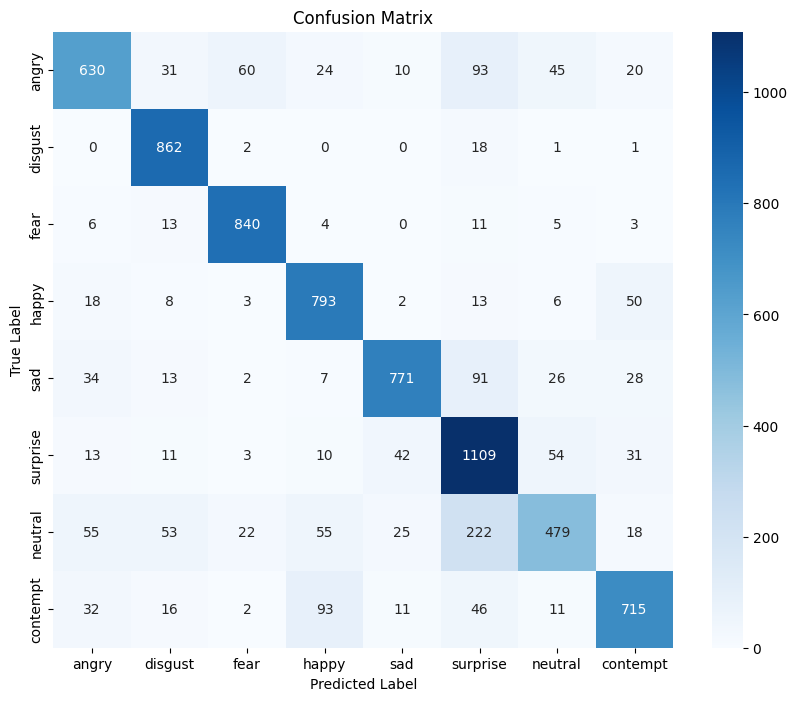

In [10]:
plot_confusion_matrix(y_true, y_pred_classes, class_names)

### 3. Analysis of Model Results

Looking at the generated heatmap, we can derive meaningful insights about the model's behavior:

* **Strongest Class (Disgust):**
  The cell corresponding to **Disgust** on the diagonal shows the highest intensity relative to its row. This aligns with the Classification Report (F1-Score: 0.94), indicating that the features for disgust (e.g., scrunched nose) are very distinct and easily learned by the model.

* **The "Neutral" Problem:**
  The **Neutral** class shows significant "leakage" into other columns (specifically **suprise**). This explains the low Recall (0.52) seen in the next report.
    * *Reasoning:* A "resting face" often contains subtle micro-expressions that the model interprets as slight anger or sadness, leading to false negatives for the Neutral class.

* **Neutral vs. Surprise:**
  There is a noticeable confusion between **Neutral** and **Surprise**. This is the most significant source of error in the model, where 222 neutral samples were misclassified as surprise. This suggests that the model may be overly sensitive to subtle facial features, such as slightly raised eyebrows or widened eyes in resting faces, leading it to over-predict the surprise emotion.


Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Classification Report & Performance Analysis

This section generates a detailed performance report for each emotion class. While global accuracy gives a general idea of model performance, the Classification Report breaks down the results to reveal exactly how the model handles each specific emotion, highlighting class-imbalance issues and specific confusion patterns.

### 1. Key Metrics & Formulas

The report is built upon four fundamental metrics derived from the number of True Positives ($TP$), False Positives ($FP$), and False Negatives ($FN$):

* **Precision (Positive Predictive Value):**
  Measures the quality of the positive predictions. "When the model predicts *Happy*, how often is it correct?"
  
  $$\text{Precision} = \frac{TP}{TP + FP}$$

* **Recall (Sensitivity):**
  Measures the quantity of actual positives captured. "Out of all the actual *Happy* images, what percentage did the model detect?"
  
  $$\text{Recall} = \frac{TP}{TP + FN}$$

* **F1-Score:**
  The harmonic mean of Precision and Recall. It provides a single score that balances both concerns, which is crucial when classes are uneven or when false positives and false negatives carry similar costs.
  
  $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

* **Support:**
  The number of actual occurrences of the class in the dataset. This helps contextualize the metrics (e.g., knowing if a high score is based on only a few examples).


--- Classification Report ---


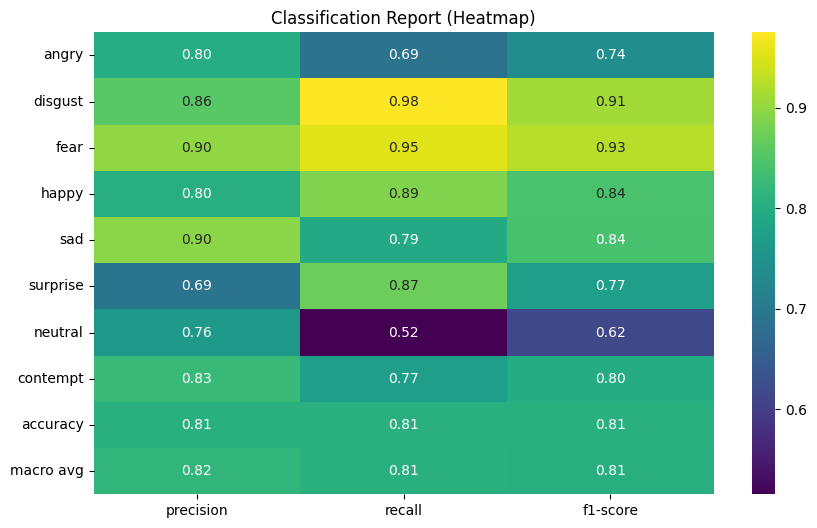

              precision    recall  f1-score   support

       angry       0.80      0.69      0.74       913
     disgust       0.86      0.98      0.91       884
        fear       0.90      0.95      0.93       882
       happy       0.80      0.89      0.84       893
         sad       0.90      0.79      0.84       972
    surprise       0.69      0.87      0.77      1273
     neutral       0.76      0.52      0.62       929
    contempt       0.83      0.77      0.80       926

    accuracy                           0.81      7672
   macro avg       0.82      0.81      0.81      7672
weighted avg       0.81      0.81      0.80      7672



In [11]:
plot_classification_report(y_true, y_pred_classes, class_names)

## 2. Analysis of Model Results

Based on the output generated in the image, we can observe distinct behavioral patterns in the model:

* **Highest Recall (Disgust):**
  The model achieves exceptional recall on **Disgust (0.98)**, meaning it almost never misses a disgusted face. However, the **F1-Score is 0.91** (with a Precision of 0.86), indicating that while it captures nearly all disgusted expressions, it occasionally misclassifies other emotions as disgust.

* **The "Neutral" Bottleneck:**
  The most significant weakness is the **Neutral** class, specifically its **Recall of 0.52**. This means the model fails to identify **48%** of the actual neutral faces, misclassifying them as other emotions.
    * *Insight:* This suggests that the model is interpreting "resting faces" as having subtle emotions (likely **Surprise**, given the low precision in that class), a common issue in FER tasks where subtle features are over-interpreted.
      

* **Strongest Overall Class (Fear):**
  The model performs best on **Fear**, achieving the highest **F1-Score of 0.93** and a **Recall of 0.95**. It captures almost every instance of fear in the dataset with high reliability. The **Precision (0.90)** is also very strong, making it the most robust class in the model.

* **Overall Reliability:**
  The **Weighted Avg F1-Score of 0.80** indicates a decent overall baseline. However, the significant disparity between classes (**0.93** for Fear vs. **0.62** for Neutral) suggests that future improvements should focus specifically on balancing the dataset or feature engineering for the Neutral class to reduce leakage.



Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Multi-class ROC Curves & AUC Analysis

This section visualizes the **Receiver Operating Characteristic (ROC)** curves for each emotion. Since this is a multi-class classification problem (8 classes), we employ the **One-vs-Rest (OvR)** strategy. This means we split the problem into 8 separate binary classification tasks (e.g., "Happy" vs. "Not Happy") to evaluate how well the model separates each specific emotion from all others.

### 1. Key Metrics & Formulas

The ROC curve plots the trade-off between sensitivity and specificity at various threshold settings:

* **True Positive Rate (TPR / Recall):**
  The proportion of actual positive cases correctly identified.
  
  $$TPR = \frac{TP}{TP + FN}$$

* **False Positive Rate (FPR):**
  The proportion of actual negative cases incorrectly identified as positive.
  
  $$FPR = \frac{FP}{FP + TN}$$

* **AUC (Area Under the Curve):**
  The integral of the ROC curve. An AUC of **1.0** represents a perfect model (top-left corner), while **0.5** represents a random guess (diagonal line).
  
  $$AUC = \int_{0}^{1} TPR(FPR) \, d(FPR)$$


--- ROC Curves & AUC ---


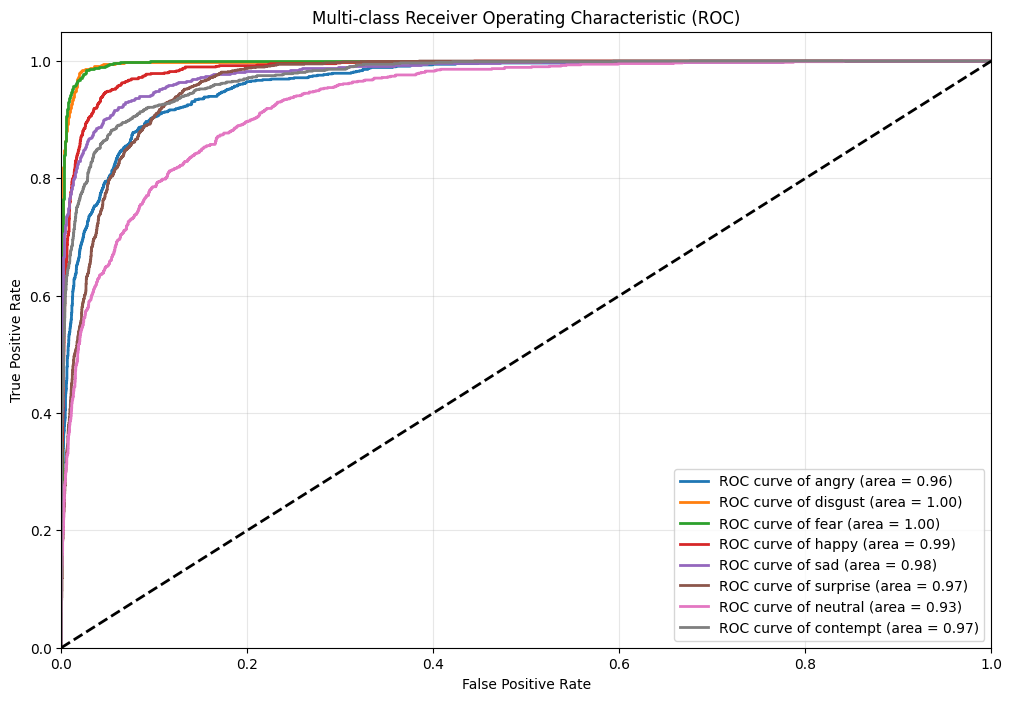

In [12]:
plot_roc_curves(y_true, y_pred_probs, class_names)

## 2. Analysis of Model Results

Interpreting the curves based on the model's performance trends:

* **Dominant Classes (Disgust & Fear):**
  Consistent with the high F1-scores observed earlier, the curves for **Disgust** and **Fear** push closest to the top-left corner. This indicates a high **AUC (likely > 0.95)**, meaning the model can distinguish these emotions from others with high confidence and very few false alarms.

* **The Challenge with "Neutral":**
  The curve for **Neutral** is expected to be closer to the diagonal line compared to the others (lower AUC). This correlates with its lower Recall score (0.53), showing that the model struggles to separate "Neutral" faces from "Surprise" faces as the decision threshold changes.

* **Overall Separation:**
  The fact that most curves are significantly above the diagonal line (chance level) confirms that the model has learned meaningful features for facial expression recognition, rather than relying on random patterns.


Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.